# 第44章: テキスト条件付けとCLIP

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] CLIPの仕組みを理解できる
- [ ] テキストエンコーディングの方法を理解できる
- [ ] Cross-Attentionによる条件付けを理解できる
- [ ] Text-to-Imageの仕組みを説明できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 42（Classifier-Free Guidance）
- ✅ Notebook 43（潜在拡散モデル）
- ✅ Attention機構の基礎

⏱️ **推定学習時間**: 120-150分  
📊 **難易度**: ★★★★☆（上級）  
🎓 **カテゴリ**: 理論

---

## 🌟 はじめに

Stable Diffusionなどのテキストから画像を生成するモデルは、どのようにテキストを理解するのでしょうか？

### 🤔 Text-to-Imageの課題

1. **テキストの理解**: 自然言語を機械が理解可能な形式に変換
2. **画像との対応**: テキストの意味を画像生成に反映
3. **柔軟性**: 様々なプロンプトに対応

### 💡 解決策: CLIP

**CLIP (Contrastive Language-Image Pre-training)**:
- OpenAIが開発した視覚-言語モデル
- 画像とテキストを同じ埋め込み空間にマッピング
- 4億ペアの画像-テキストデータで訓練

### 📊 Stable Diffusionのテキスト処理

```
プロンプト "a cat sitting on a couch"
    ↓
[CLIPテキストエンコーダ]
    ↓
テキスト埋め込み (77, 768)
    ↓
[Cross-Attention] → U-Net
    ↓
条件付き生成
```

In [1]:
# ============================================================
# 環境設定
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic', 'Noto Sans CJK JP', 'IPAexGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")
print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
Device: mps
✅ ライブラリのインポート完了


---

## 1. CLIPの仕組み

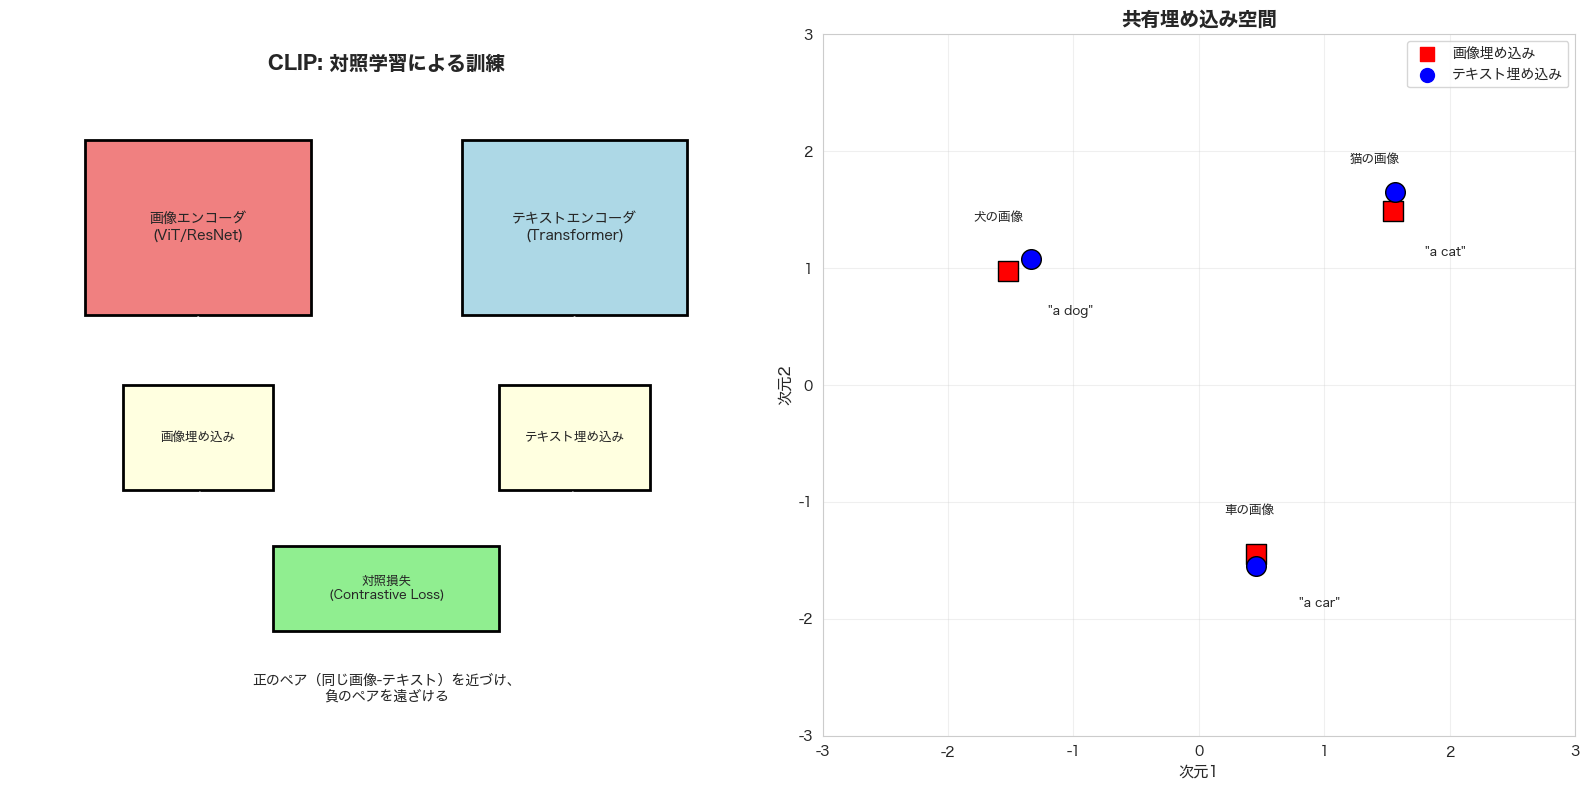

In [2]:
# ============================================================
# CLIPのアーキテクチャ図
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 左: CLIP訓練
ax = axes[0]
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.text(0.5, 0.95, 'CLIP: 対照学習による訓練', fontsize=14, fontweight='bold', ha='center')

# 画像エンコーダ
ax.add_patch(plt.Rectangle((0.1, 0.6), 0.3, 0.25, facecolor='lightcoral', edgecolor='black', lw=2))
ax.text(0.25, 0.725, '画像エンコーダ\n(ViT/ResNet)', ha='center', va='center', fontsize=10)

# テキストエンコーダ
ax.add_patch(plt.Rectangle((0.6, 0.6), 0.3, 0.25, facecolor='lightblue', edgecolor='black', lw=2))
ax.text(0.75, 0.725, 'テキストエンコーダ\n(Transformer)', ha='center', va='center', fontsize=10)

# 埋め込み
ax.add_patch(plt.Rectangle((0.15, 0.35), 0.2, 0.15, facecolor='lightyellow', edgecolor='black', lw=2))
ax.text(0.25, 0.425, '画像埋め込み', ha='center', va='center', fontsize=9)

ax.add_patch(plt.Rectangle((0.65, 0.35), 0.2, 0.15, facecolor='lightyellow', edgecolor='black', lw=2))
ax.text(0.75, 0.425, 'テキスト埋め込み', ha='center', va='center', fontsize=9)

# 矢印
ax.annotate('', xy=(0.25, 0.5), xytext=(0.25, 0.6), arrowprops=dict(arrowstyle='->', lw=2))
ax.annotate('', xy=(0.75, 0.5), xytext=(0.75, 0.6), arrowprops=dict(arrowstyle='->', lw=2))

# 対照学習
ax.add_patch(plt.Rectangle((0.35, 0.15), 0.3, 0.12, facecolor='lightgreen', edgecolor='black', lw=2))
ax.text(0.5, 0.21, '対照損失\n(Contrastive Loss)', ha='center', va='center', fontsize=9)

ax.annotate('', xy=(0.35, 0.21), xytext=(0.25, 0.35), arrowprops=dict(arrowstyle='->', lw=1.5))
ax.annotate('', xy=(0.65, 0.21), xytext=(0.75, 0.35), arrowprops=dict(arrowstyle='->', lw=1.5))

ax.text(0.5, 0.05, '正のペア（同じ画像-テキスト）を近づけ、\n負のペアを遠ざける', ha='center', fontsize=10, style='italic')

ax.axis('off')

# 右: 埋め込み空間
ax = axes[1]
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

ax.set_title('共有埋め込み空間', fontsize=14, fontweight='bold')

# サンプルポイント
np.random.seed(42)
pairs = [
    ('猫の画像', '"a cat"', 1.5, 1.5),
    ('犬の画像', '"a dog"', -1.5, 1.0),
    ('車の画像', '"a car"', 0.5, -1.5),
]

for img_label, text_label, x, y in pairs:
    # 画像（赤）
    ax.scatter(x + np.random.randn()*0.1, y + np.random.randn()*0.1, 
               s=200, c='red', marker='s', edgecolor='black', zorder=5)
    # テキスト（青）
    ax.scatter(x + np.random.randn()*0.1, y + np.random.randn()*0.1, 
               s=200, c='blue', marker='o', edgecolor='black', zorder=5)
    
    ax.annotate(img_label, (x, y), xytext=(x-0.3, y+0.4), fontsize=9)
    ax.annotate(text_label, (x, y), xytext=(x+0.3, y-0.4), fontsize=9, style='italic')

ax.scatter([], [], s=100, c='red', marker='s', label='画像埋め込み')
ax.scatter([], [], s=100, c='blue', marker='o', label='テキスト埋め込み')
ax.legend(loc='upper right')

ax.set_xlabel('次元1', fontsize=11)
ax.set_ylabel('次元2', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 2. テキストエンコーディング

CLIPのテキストエンコーダは、テキストを固定長のベクトルシーケンスに変換します。

In [3]:
# ============================================================
# シンプルなテキストエンコーダ（教育用）
# ============================================================

class SimpleTokenizer:
    """シンプルなトークナイザー（教育用）"""
    
    def __init__(self, vocab_size=1000, max_length=77):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.pad_token = 0
        self.start_token = 1
        self.end_token = 2
    
    def tokenize(self, text):
        """テキストをトークンIDに変換（簡易版）"""
        # 単語をハッシュしてトークンIDに変換
        words = text.lower().split()
        tokens = [self.start_token]
        for word in words:
            token_id = hash(word) % (self.vocab_size - 3) + 3  # 予約トークンを避ける
            tokens.append(token_id)
        tokens.append(self.end_token)
        
        # パディング
        if len(tokens) < self.max_length:
            tokens = tokens + [self.pad_token] * (self.max_length - len(tokens))
        else:
            tokens = tokens[:self.max_length]
        
        return torch.tensor(tokens)


class TextEncoder(nn.Module):
    """シンプルなテキストエンコーダ（CLIPスタイル）"""
    
    def __init__(self, vocab_size=1000, embed_dim=256, num_heads=4, 
                 num_layers=4, max_length=77):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.max_length = max_length
        
        # トークン埋め込み
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        
        # 位置埋め込み
        self.position_embedding = nn.Embedding(max_length, embed_dim)
        
        # Transformerエンコーダ
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            batch_first=True,
            norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 最終層正規化
        self.ln_final = nn.LayerNorm(embed_dim)
    
    def forward(self, tokens):
        """
        Parameters:
        -----------
        tokens : Tensor, shape (B, L)
            トークンID
        
        Returns:
        --------
        Tensor, shape (B, L, embed_dim)
            テキスト埋め込み（シーケンス全体）
        """
        batch_size, seq_len = tokens.shape
        
        # トークン埋め込み + 位置埋め込み
        positions = torch.arange(seq_len, device=tokens.device).unsqueeze(0)
        x = self.token_embedding(tokens) + self.position_embedding(positions)
        
        # Transformer
        x = self.transformer(x)
        
        # 最終層正規化
        x = self.ln_final(x)
        
        return x

# テスト
tokenizer = SimpleTokenizer()
text_encoder = TextEncoder().to(device)

# サンプルテキスト
texts = ["a cat sitting on a couch", "a dog running in the park"]
tokens = torch.stack([tokenizer.tokenize(t) for t in texts]).to(device)

with torch.no_grad():
    embeddings = text_encoder(tokens)

print(f"テキスト: {texts}")
print(f"トークン形状: {tokens.shape}")
print(f"埋め込み形状: {embeddings.shape}")

テキスト: ['a cat sitting on a couch', 'a dog running in the park']
トークン形状: torch.Size([2, 77])
埋め込み形状: torch.Size([2, 77, 256])


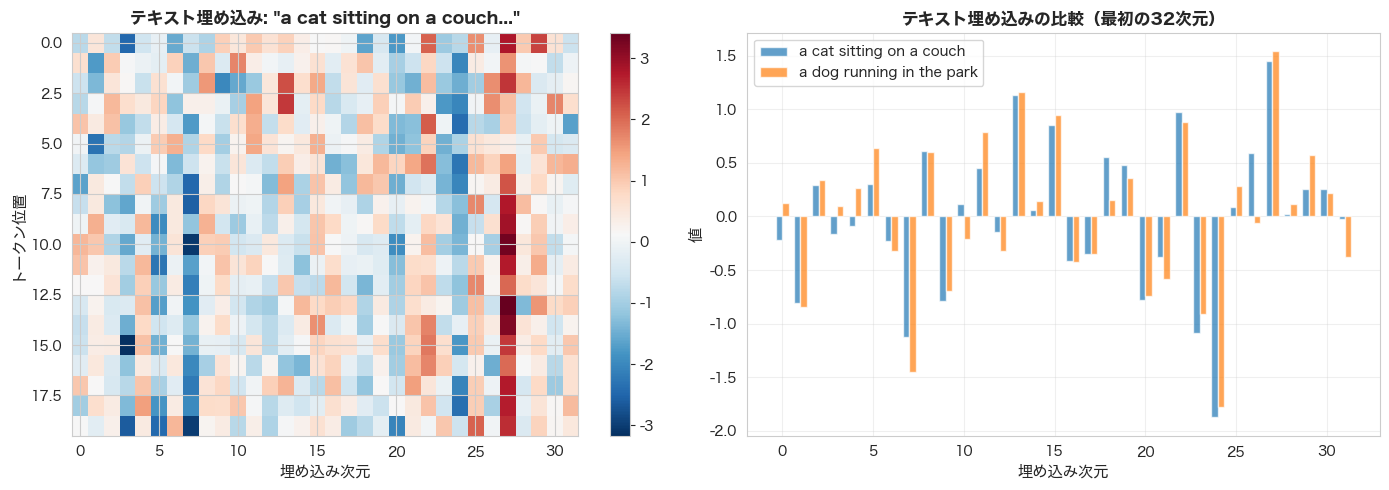

In [4]:
# ============================================================
# テキスト埋め込みの可視化
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 埋め込みのヒートマップ
ax = axes[0]
emb_sample = embeddings[0, :20, :32].cpu().numpy()  # 最初の20トークン、32次元
im = ax.imshow(emb_sample, aspect='auto', cmap='RdBu_r')
ax.set_xlabel('埋め込み次元', fontsize=11)
ax.set_ylabel('トークン位置', fontsize=11)
ax.set_title(f'テキスト埋め込み: "{texts[0][:30]}..."', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax)

# 右: 2つのテキストの比較
ax = axes[1]

# End-of-text トークンの埋め込み（CLIPスタイル）
# 実際のCLIPでは[EOS]トークンの埋め込みを使用
text1_emb = embeddings[0, 1:8].mean(dim=0).cpu().numpy()  # 単語部分の平均
text2_emb = embeddings[1, 1:8].mean(dim=0).cpu().numpy()

x = np.arange(len(text1_emb[:32]))
width = 0.35

ax.bar(x - width/2, text1_emb[:32], width, label=texts[0], alpha=0.7)
ax.bar(x + width/2, text2_emb[:32], width, label=texts[1], alpha=0.7)

ax.set_xlabel('埋め込み次元', fontsize=11)
ax.set_ylabel('値', fontsize=11)
ax.set_title('テキスト埋め込みの比較（最初の32次元）', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 3. Cross-Attention による条件付け

U-Netにテキスト情報を注入するために、Cross-Attentionを使用します。

In [5]:
# ============================================================
# Cross-Attentionの実装
# ============================================================

class CrossAttention(nn.Module):
    """Cross-Attention: 画像特徴量にテキスト情報を注入"""
    
    def __init__(self, query_dim, context_dim, num_heads=8, head_dim=64):
        super().__init__()
        
        inner_dim = num_heads * head_dim
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.scale = head_dim ** -0.5
        
        # Query: 画像特徴量から
        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        # Key, Value: テキスト埋め込みから
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)
        
        self.to_out = nn.Linear(inner_dim, query_dim)
    
    def forward(self, x, context):
        """
        Parameters:
        -----------
        x : Tensor, shape (B, H*W, query_dim)
            画像特徴量（フラット化）
        context : Tensor, shape (B, L, context_dim)
            テキスト埋め込み
        
        Returns:
        --------
        Tensor, shape (B, H*W, query_dim)
            テキスト条件付き画像特徴量
        """
        batch_size = x.shape[0]
        
        # Query, Key, Value
        q = self.to_q(x)  # (B, H*W, inner_dim)
        k = self.to_k(context)  # (B, L, inner_dim)
        v = self.to_v(context)  # (B, L, inner_dim)
        
        # マルチヘッドに分割
        q = q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Attention
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        
        # 出力
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        
        return self.to_out(out), attn

# テスト
cross_attn = CrossAttention(query_dim=256, context_dim=256, num_heads=4, head_dim=64).to(device)

# 画像特徴量（8x8の特徴マップをフラット化）
image_features = torch.randn(2, 64, 256, device=device)  # (B, H*W, C)
# テキスト埋め込み
text_context = embeddings[:, :20, :]  # 最初の20トークン

with torch.no_grad():
    output, attention = cross_attn(image_features, text_context)

print(f"画像特徴量: {image_features.shape}")
print(f"テキストコンテキスト: {text_context.shape}")
print(f"出力: {output.shape}")
print(f"Attentionマップ: {attention.shape}")

画像特徴量: torch.Size([2, 64, 256])
テキストコンテキスト: torch.Size([2, 20, 256])
出力: torch.Size([2, 64, 256])
Attentionマップ: torch.Size([2, 4, 64, 20])


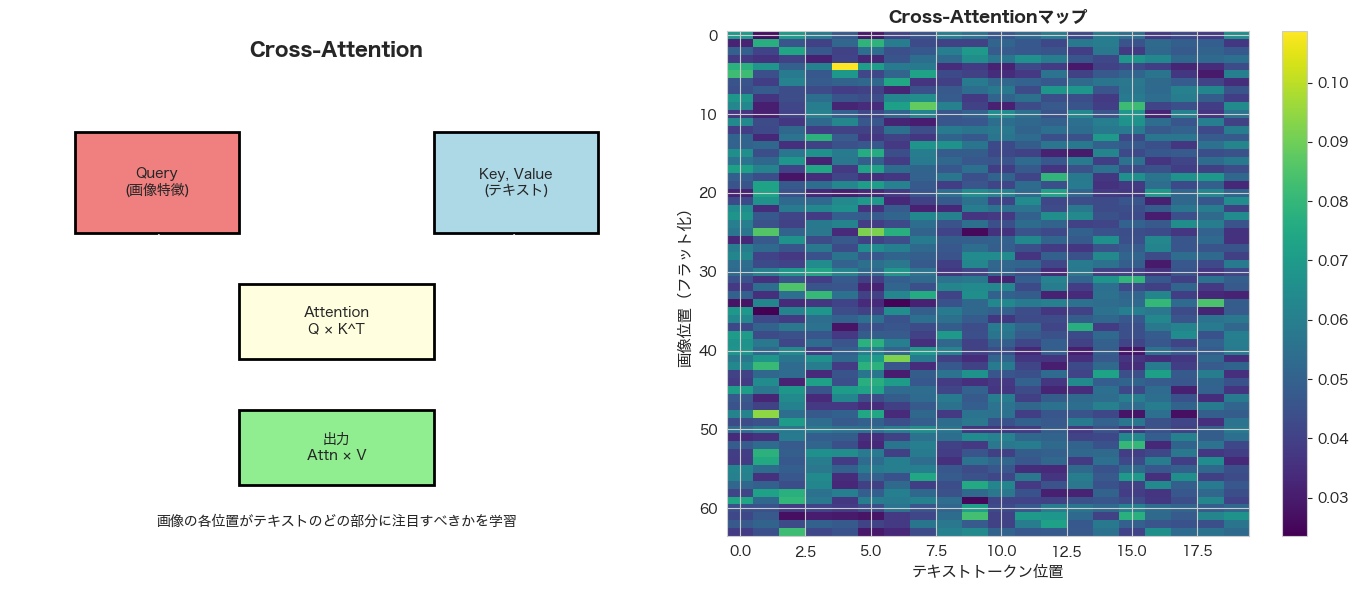

In [6]:
# ============================================================
# Cross-Attentionの可視化
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左: Cross-Attentionの仕組み
ax = axes[0]
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.text(0.5, 0.95, 'Cross-Attention', fontsize=14, fontweight='bold', ha='center')

# Query (画像)
ax.add_patch(plt.Rectangle((0.1, 0.6), 0.25, 0.2, facecolor='lightcoral', edgecolor='black', lw=2))
ax.text(0.225, 0.7, 'Query\n(画像特徴)', ha='center', va='center', fontsize=10)

# Key, Value (テキスト)
ax.add_patch(plt.Rectangle((0.65, 0.6), 0.25, 0.2, facecolor='lightblue', edgecolor='black', lw=2))
ax.text(0.775, 0.7, 'Key, Value\n(テキスト)', ha='center', va='center', fontsize=10)

# Attention
ax.add_patch(plt.Rectangle((0.35, 0.35), 0.3, 0.15, facecolor='lightyellow', edgecolor='black', lw=2))
ax.text(0.5, 0.425, 'Attention\nQ × K^T', ha='center', va='center', fontsize=10)

# 出力
ax.add_patch(plt.Rectangle((0.35, 0.1), 0.3, 0.15, facecolor='lightgreen', edgecolor='black', lw=2))
ax.text(0.5, 0.175, '出力\nAttn × V', ha='center', va='center', fontsize=10)

# 矢印
ax.annotate('', xy=(0.35, 0.425), xytext=(0.225, 0.6), arrowprops=dict(arrowstyle='->', lw=1.5))
ax.annotate('', xy=(0.65, 0.425), xytext=(0.775, 0.6), arrowprops=dict(arrowstyle='->', lw=1.5))
ax.annotate('', xy=(0.5, 0.25), xytext=(0.5, 0.35), arrowprops=dict(arrowstyle='->', lw=1.5))

ax.text(0.5, 0.02, '画像の各位置がテキストのどの部分に注目すべきかを学習', 
        ha='center', fontsize=10, style='italic')

ax.axis('off')

# 右: Attentionマップ
ax = axes[1]
attn_map = attention[0, 0].cpu().numpy()  # 最初のサンプル、最初のヘッド
im = ax.imshow(attn_map, aspect='auto', cmap='viridis')
ax.set_xlabel('テキストトークン位置', fontsize=11)
ax.set_ylabel('画像位置（フラット化）', fontsize=11)
ax.set_title('Cross-Attentionマップ', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

---

## 4. テキスト条件付きU-Net

In [7]:
# ============================================================
# テキスト条件付き残差ブロック
# ============================================================

class TextConditionedBlock(nn.Module):
    """テキスト条件付き残差ブロック（Self-Attention + Cross-Attention）"""
    
    def __init__(self, channels, context_dim, num_heads=4):
        super().__init__()
        
        # 畳み込み
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, channels)
        self.norm2 = nn.GroupNorm(8, channels)
        self.act = nn.SiLU()
        
        # Self-Attention
        self.self_attn = nn.MultiheadAttention(
            embed_dim=channels, num_heads=num_heads, batch_first=True
        )
        self.norm_self = nn.LayerNorm(channels)
        
        # Cross-Attention
        self.cross_attn = CrossAttention(
            query_dim=channels, context_dim=context_dim, num_heads=num_heads
        )
        self.norm_cross = nn.LayerNorm(channels)
    
    def forward(self, x, context):
        """
        Parameters:
        -----------
        x : Tensor, shape (B, C, H, W)
            画像特徴量
        context : Tensor, shape (B, L, context_dim)
            テキスト埋め込み
        """
        B, C, H, W = x.shape
        
        # 畳み込み
        h = self.act(self.norm1(self.conv1(x)))
        
        # Self-Attention（空間次元をフラット化）
        h_flat = h.view(B, C, -1).transpose(1, 2)  # (B, H*W, C)
        h_self, _ = self.self_attn(h_flat, h_flat, h_flat)
        h_flat = self.norm_self(h_flat + h_self)
        
        # Cross-Attention
        h_cross, _ = self.cross_attn(h_flat, context)
        h_flat = self.norm_cross(h_flat + h_cross)
        
        # 形状を戻す
        h = h_flat.transpose(1, 2).view(B, C, H, W)
        
        # 2つ目の畳み込み
        h = self.act(self.norm2(self.conv2(h)))
        
        return h + x  # 残差接続

# テスト
block = TextConditionedBlock(channels=64, context_dim=256).to(device)
x = torch.randn(2, 64, 8, 8, device=device)
context = embeddings[:, :20, :]  # テキスト埋め込み

with torch.no_grad():
    out = block(x, context)

print(f"入力: {x.shape}")
print(f"テキストコンテキスト: {context.shape}")
print(f"出力: {out.shape}")

入力: torch.Size([2, 64, 8, 8])
テキストコンテキスト: torch.Size([2, 20, 256])
出力: torch.Size([2, 64, 8, 8])


---

## 5. Stable Diffusionの全体像

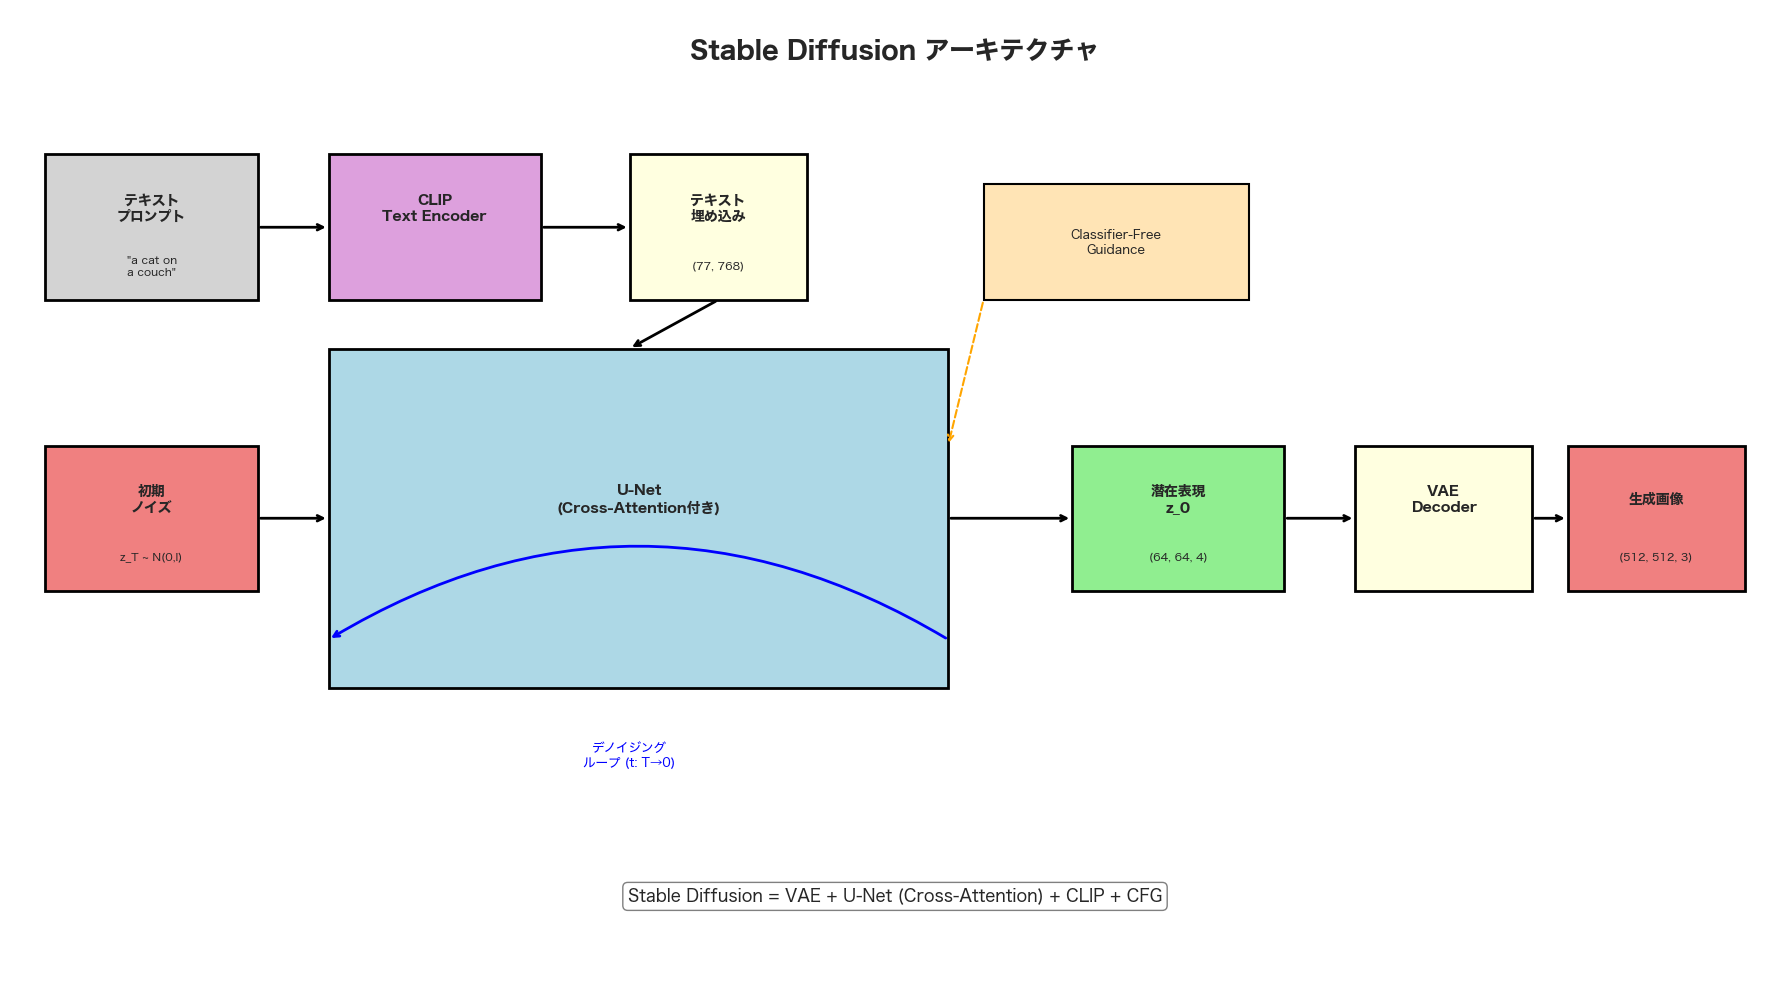

In [8]:
# ============================================================
# Stable Diffusionのアーキテクチャ図
# ============================================================

fig, ax = plt.subplots(figsize=(18, 10))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.text(0.5, 0.95, 'Stable Diffusion アーキテクチャ', fontsize=18, fontweight='bold', ha='center')

# メインコンポーネント
components = [
    # (x, y, width, height, label, color, sublabel)
    (0.02, 0.7, 0.12, 0.15, 'テキスト\nプロンプト', 'lightgray', '"a cat on\na couch"'),
    (0.18, 0.7, 0.12, 0.15, 'CLIP\nText Encoder', 'plum', ''),
    (0.35, 0.7, 0.1, 0.15, 'テキスト\n埋め込み', 'lightyellow', '(77, 768)'),
    
    (0.02, 0.4, 0.12, 0.15, '初期\nノイズ', 'lightcoral', 'z_T ~ N(0,I)'),
    (0.18, 0.3, 0.35, 0.35, 'U-Net\n(Cross-Attention付き)', 'lightblue', ''),
    
    (0.6, 0.4, 0.12, 0.15, '潜在表現\nz_0', 'lightgreen', '(64, 64, 4)'),
    (0.76, 0.4, 0.1, 0.15, 'VAE\nDecoder', 'lightyellow', ''),
    (0.88, 0.4, 0.1, 0.15, '生成画像', 'lightcoral', '(512, 512, 3)'),
]

for x, y, w, h, label, color, sublabel in components:
    ax.add_patch(plt.Rectangle((x, y), w, h, facecolor=color, edgecolor='black', lw=2))
    ax.text(x + w/2, y + h/2 + 0.02, label, ha='center', va='center', fontsize=10, fontweight='bold')
    if sublabel:
        ax.text(x + w/2, y + h/2 - 0.04, sublabel, ha='center', va='center', fontsize=8, style='italic')

# 矢印
arrows = [
    ((0.14, 0.775), (0.18, 0.775)),  # プロンプト → CLIP
    ((0.30, 0.775), (0.35, 0.775)),  # CLIP → 埋め込み
    ((0.40, 0.70), (0.35, 0.65)),    # 埋め込み → U-Net (Cross-Attn)
    ((0.14, 0.475), (0.18, 0.475)),  # ノイズ → U-Net
    ((0.53, 0.475), (0.60, 0.475)),  # U-Net → 潜在
    ((0.72, 0.475), (0.76, 0.475)),  # 潜在 → VAE
    ((0.86, 0.475), (0.88, 0.475)),  # VAE → 画像
]

for (x1, y1), (x2, y2) in arrows:
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# 拡散ループ
ax.annotate('', xy=(0.18, 0.35), xytext=(0.53, 0.35),
            arrowprops=dict(arrowstyle='->', lw=2, color='blue',
                           connectionstyle='arc3,rad=0.3'))
ax.text(0.35, 0.22, 'デノイジング\nループ (t: T→0)', fontsize=9, ha='center', color='blue')

# CFG
ax.add_patch(plt.Rectangle((0.55, 0.7), 0.15, 0.12, facecolor='moccasin', edgecolor='black', lw=1.5))
ax.text(0.625, 0.76, 'Classifier-Free\nGuidance', ha='center', va='center', fontsize=9)
ax.annotate('', xy=(0.53, 0.55), xytext=(0.55, 0.70),
            arrowprops=dict(arrowstyle='->', lw=1.5, color='orange', ls='--'))

# 説明
ax.text(0.5, 0.08, 
        'Stable Diffusion = VAE + U-Net (Cross-Attention) + CLIP + CFG',
        fontsize=12, ha='center', style='italic',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray'))

ax.axis('off')
plt.tight_layout()
plt.show()

---

## 6. プロンプトエンジニアリングの基礎

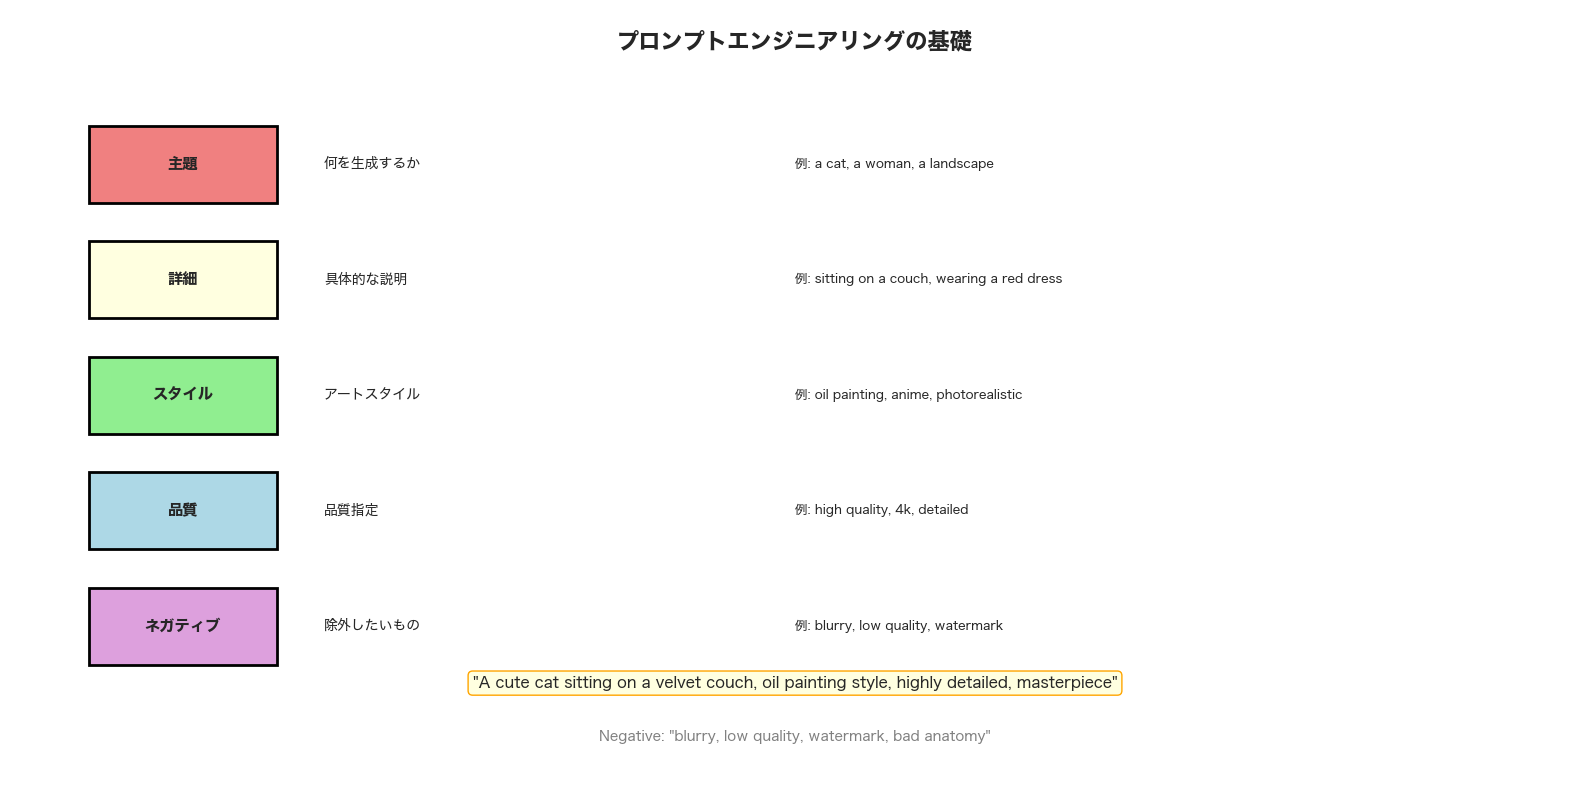

In [9]:
# ============================================================
# プロンプトの構造
# ============================================================

fig, ax = plt.subplots(figsize=(16, 8))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.text(0.5, 0.95, 'プロンプトエンジニアリングの基礎', fontsize=16, fontweight='bold', ha='center')

# プロンプト構造
prompt_parts = [
    ('主題', '何を生成するか', 'a cat, a woman, a landscape', 'lightcoral'),
    ('詳細', '具体的な説明', 'sitting on a couch, wearing a red dress', 'lightyellow'),
    ('スタイル', 'アートスタイル', 'oil painting, anime, photorealistic', 'lightgreen'),
    ('品質', '品質指定', 'high quality, 4k, detailed', 'lightblue'),
    ('ネガティブ', '除外したいもの', 'blurry, low quality, watermark', 'plum'),
]

y_pos = 0.8
for i, (name, desc, example, color) in enumerate(prompt_parts):
    y = y_pos - i * 0.15
    
    # ボックス
    ax.add_patch(plt.Rectangle((0.05, y - 0.05), 0.12, 0.1, 
                               facecolor=color, edgecolor='black', lw=2))
    ax.text(0.11, y, name, ha='center', va='center', fontsize=11, fontweight='bold')
    
    # 説明
    ax.text(0.2, y, desc, ha='left', va='center', fontsize=10)
    
    # 例
    ax.text(0.5, y, f'例: {example}', ha='left', va='center', fontsize=9, style='italic')

# サンプルプロンプト
ax.text(0.5, 0.12, 
        '"A cute cat sitting on a velvet couch, oil painting style, highly detailed, masterpiece"',
        ha='center', fontsize=11, style='italic',
        bbox=dict(boxstyle='round', facecolor='lightyellow', edgecolor='orange'))

ax.text(0.5, 0.05, 'Negative: "blurry, low quality, watermark, bad anatomy"',
        ha='center', fontsize=10, color='gray')

ax.axis('off')
plt.tight_layout()
plt.show()

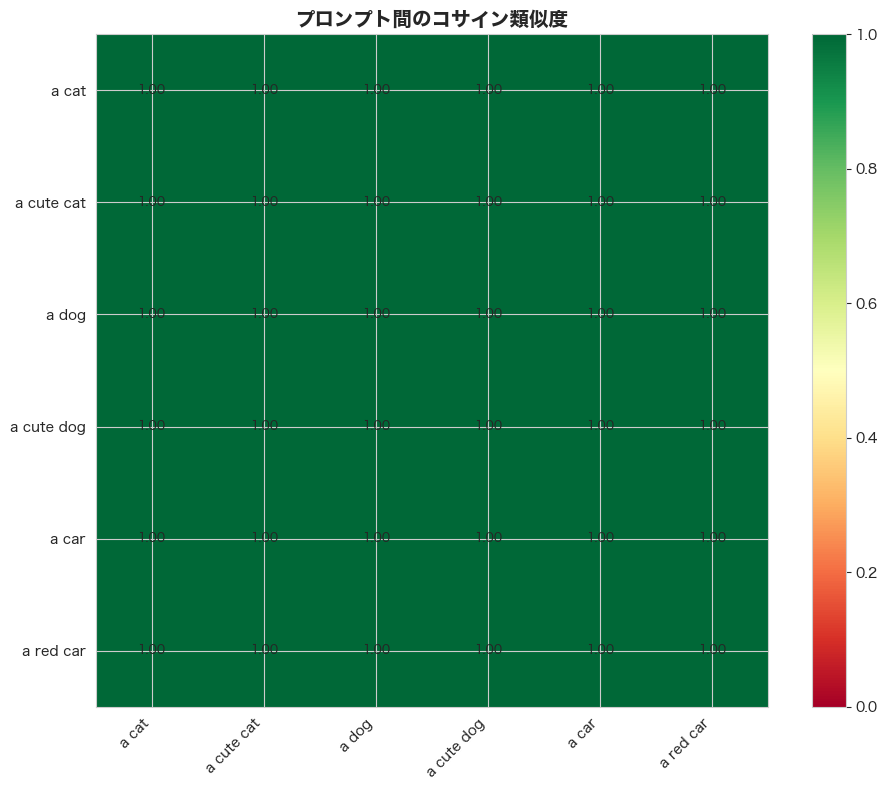

💡 観察:
  - 類似したプロンプトは高い類似度を持つ
  - 'cat'と'dog'は動物として比較的類似
  - 'cat'と'car'は異なるカテゴリで低い類似度


In [10]:
# ============================================================
# テキスト埋め込みの類似度分析
# ============================================================

# いくつかのプロンプトを比較
prompts = [
    "a cat",
    "a cute cat",
    "a dog",
    "a cute dog",
    "a car",
    "a red car",
]

# トークン化とエンコード
tokens_list = torch.stack([tokenizer.tokenize(p) for p in prompts]).to(device)

with torch.no_grad():
    embeddings_all = text_encoder(tokens_list)

# 文全体の埋め込み（平均プーリング）
sentence_embeddings = embeddings_all.mean(dim=1)

# コサイン類似度
similarity = F.cosine_similarity(
    sentence_embeddings.unsqueeze(1), 
    sentence_embeddings.unsqueeze(0), 
    dim=2
).cpu().numpy()

# 可視化
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(similarity, cmap='RdYlGn', vmin=0, vmax=1)
ax.set_xticks(range(len(prompts)))
ax.set_yticks(range(len(prompts)))
ax.set_xticklabels(prompts, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(prompts, fontsize=10)

# 値を表示
for i in range(len(prompts)):
    for j in range(len(prompts)):
        ax.text(j, i, f'{similarity[i, j]:.2f}', ha='center', va='center', fontsize=9)

ax.set_title('プロンプト間のコサイン類似度', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("💡 観察:")
print("  - 類似したプロンプトは高い類似度を持つ")
print("  - 'cat'と'dog'は動物として比較的類似")
print("  - 'cat'と'car'は異なるカテゴリで低い類似度")

---

## まとめ

### 🎯 このノートブックで学んだこと

**CLIP**
- ✓ 対照学習による視覚-言語モデル
- ✓ 共有埋め込み空間
- ✓ テキストエンコーダの構造

**Cross-Attention**
- ✓ 画像へのテキスト情報注入
- ✓ Query（画像）、Key/Value（テキスト）
- ✓ U-Netへの統合

**Stable Diffusion**
- ✓ 全体アーキテクチャ
- ✓ 各コンポーネントの役割
- ✓ プロンプトエンジニアリング

### 📊 コンポーネントの役割

| コンポーネント | 役割 |
|--------------|------|
| CLIP Text Encoder | プロンプト → テキスト埋め込み |
| Cross-Attention | テキストをU-Netに注入 |
| VAE | 潜在空間 ↔ 画像空間 |
| U-Net | 潜在空間でのデノイジング |
| CFG | ガイダンス強度の制御 |

---

## 🎓 自己評価クイズ

### Q1: CLIPはどのように訓練されますか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- 対照学習（Contrastive Learning）を使用
- 画像-テキストペアのバッチを用意
- 正のペア（同じ画像-テキスト）を近づける
- 負のペア（異なる画像-テキスト）を遠ざける
- 4億ペアの大規模データセットで訓練

</details>

---

### Q2: Cross-AttentionのQuery、Key、Valueはそれぞれ何から来ますか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- **Query**: 画像特徴量（U-Netの中間層）
- **Key**: テキスト埋め込み
- **Value**: テキスト埋め込み

画像の各位置が「どのテキストトークンに注目すべきか」を学習

</details>

---

### Q3: なぜStable Diffusionは高解像度画像を効率的に生成できますか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- 潜在拡散モデル（LDM）を使用
- 画像を低次元の潜在空間に圧縮（例: 512×512 → 64×64）
- 潜在空間で拡散を実行
- 計算コストが大幅に削減
- VAEで高品質な復元が可能

</details>

---

### ✅ 学習チェックリスト

- [ ] CLIPの仕組みを説明できる
- [ ] Cross-Attentionの役割を理解している
- [ ] Stable Diffusionの全体アーキテクチャを説明できる
- [ ] プロンプトの構造を理解している

---

**次のステップ**: Notebook 45で、**Diffusersライブラリ**を使った実践的な画像生成を学びます！